In [6]:
!wget -O train_dataset_vprod_train.zip https://www.dropbox.com/scl/fi/ahjr9509ok502d98elja6/train_dataset_vprod_train.zip?rlkey=zvu36l571mr4cau0bmafgtphe&st=ehl5lw22&dl=0

--2024-09-07 22:37:17--  https://www.dropbox.com/scl/fi/ahjr9509ok502d98elja6/train_dataset_vprod_train.zip?rlkey=zvu36l571mr4cau0bmafgtphe
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc556833fbc1bb85162300fafe17.dl.dropboxusercontent.com/cd/0/inline/CaL6IT3fNjdcF_I9vpGx2yq7WRNOwSNt7bLemXgQkcrOZMYbq0VVwtcmQHaWVj-p-BXheIbYfXhs8hIRl1hK1CjJ10LXPPpLGlQ3lKo077S1YGPclM7c6ZKLlnLBBnO0wU5GVda-RFHQ--7qLpLfA33v/file# [following]
--2024-09-07 22:37:18--  https://uc556833fbc1bb85162300fafe17.dl.dropboxusercontent.com/cd/0/inline/CaL6IT3fNjdcF_I9vpGx2yq7WRNOwSNt7bLemXgQkcrOZMYbq0VVwtcmQHaWVj-p-BXheIbYfXhs8hIRl1hK1CjJ10LXPPpLGlQ3lKo077S1YGPclM7c6ZKLlnLBBnO0wU5GVda-RFHQ--7qLpLfA33v/file
Resolving uc556833fbc1bb85162300fafe17.dl.dropboxusercontent.com (uc556833fbc1bb85162300fafe17.dl.dropboxusercontent.com)... 1

In [7]:
!unzip train_dataset_vprod_train.zip

Archive:  train_dataset_vprod_train.zip
  inflating: vprod_train/JOB_LIST.csv  
  inflating: vprod_train/README.docx  
  inflating: vprod_train/TRAIN_RES_1.csv  
  inflating: vprod_train/TRAIN_RES_2.csv  
  inflating: vprod_train/TRAIN_RES_3.csv  
  inflating: vprod_train/TRAIN_RES_4.csv  
  inflating: vprod_train/TRAIN_RES_5.csv  
  inflating: vprod_train/TRAIN_SAL.csv  
  inflating: vprod_train/VPROD_pipeline.ipynb  


In [1]:
!pip install catboost

In [2]:
import json
from tqdm import tqdm
import pandas as pd
from scipy import stats
import numpy as np

from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('/content/vprod_train/TRAIN_SAL.csv')

<ipython-input-3-cd263999bfc7>:1: DtypeWarning: Columns (1,16,24,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/vprod_train/TRAIN_SAL.csv')


# EDA

<Axes: xlabel='salary_min', ylabel='Count'>

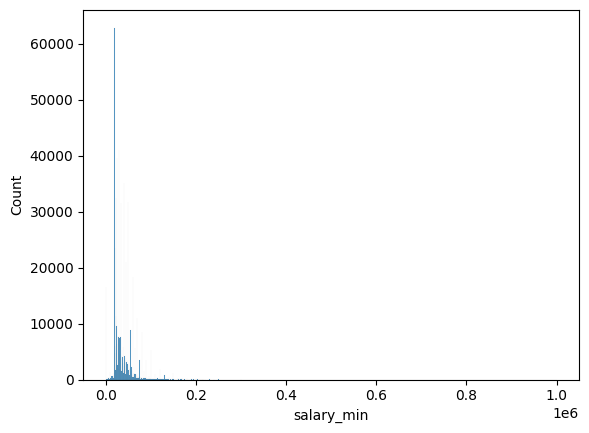

In [22]:
sns.histplot(df['salary_min'])

<Axes: xlabel='salary_min', ylabel='Count'>

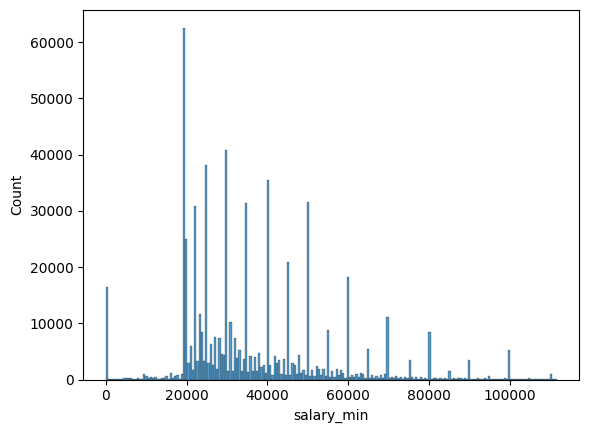

In [23]:
z = np.abs(stats.zscore(df['salary_min']))
df = df[(z < 3)]
sns.histplot(df['salary_min'])

In [26]:
((df.isnull().sum().sort_values() > df.shape[0] * 0.9))

,0
id,False
softSkills,False
accommodation_capability,False
hardSkills,False
company_code,False
...,...
contactList,True
regionNameTerm,True
foreign_workers_capability,True
oknpo_code,True


In [28]:
for i in list(df):
    print(df[i].value_counts())
    print()

id
eb9fadc8-391d-11ef-8f5c-e7d0d2cf29b1    1
4e2f52d2-fd76-11e4-8a5b-3bdbd1a6e39d    1
fafe2e23-0e2c-11e5-9cc4-3bdbd1a6e39d    1
7eb9edc1-fd76-11e4-8a5b-3bdbd1a6e39d    1
2e68ddc3-0499-11e5-b3df-3bdbd1a6e39d    1
                                       ..
a9d63821-fd7f-11e4-8a5b-3bdbd1a6e39d    1
a9e15bb5-fd7f-11e4-8a5b-3bdbd1a6e39d    1
a9d41541-fd7f-11e4-8a5b-3bdbd1a6e39d    1
a9df5fe1-fd7f-11e4-8a5b-3bdbd1a6e39d    1
60532363-fd80-11e4-8a5b-3bdbd1a6e39d    1
Name: count, Length: 620969, dtype: int64

academic_degree
Кандидат наук    222
Доктор наук       55
Name: count, dtype: int64

accommodation_capability
False    582088
True      38881
Name: count, dtype: int64

accommodation_type
DORMITORY    18824
FLAT          9215
ROOM          2479
HOUSE          894
Name: count, dtype: int64

additional_premium
30.0      9603
100.0     7253
20.0      6785
50.0      6642
25.0      6363
          ... 
6480.0       1
4566.0       1
5759.0       1
5523.0       1
5642.0       1
Name: count, Leng

# Train

In [4]:
def clean_df(df):
    df = df.drop(columns=((df.isnull().sum().sort_values() > df.shape[0] * 0.9)[-18:]).index.values.tolist()) # дропаем колонки, в которых больше 90%: "NaN"
    df = df.drop(columns=['languageKnowledge', 'hardSkills', 'softSkills']) # дропаем колонки, в которых больше 90%: "[]"
    df = df.drop(columns=['deleted', 'is_moderated', 'visibility']) # дропаем колонки, в записях которых одни и те же значения (is_moderated: True, deleted: False)
    df = df.drop(columns=['company']) # дропаем колонку, так как информация из этой колонки есть в других
    df = df.drop(columns=['salary']) # дропаем колонку, так как она совпадает с колонкой "min_salary"
    df = df.drop(columns=['id', 'data_ids'])

    df = df.drop(columns=['salary_max'])
    df = df.drop(columns=['publication_period', 'bonus_type', 'is_uzbekistan_recruitment', 'status', 'source_type']) # дропаем колонки, значение feature importance которых меньше 0.000001

    for i in ['date_create', 'date_modify', 'published_date', 'change_time']:
        df[i] = pd.to_datetime(df[i])
        df[f'{i}_year'] = df[i].dt.year
        df[f'{i}_month'] = df[i].dt.month
        df[f'{i}_day'] = df[i].dt.month
        df[f'{i}_day_of_week'] = df[i].dt.dayofweek

    # df['change_time_year'] = df['change_time'].dt.year
    df = df.drop(columns=['date_create', 'date_modify', 'published_date', 'change_time', 'company_code', 'vacancy_address_house'])

    z = np.abs(stats.zscore(df['salary_min']))
    df = df[(z < 3)]

    # for i in tqdm(range(df.shape[0])):
    #     df['company_name'] = json.loads(df['company'][i])['name']
    return df

In [5]:
cleaned_df = clean_df(df)
cleaned_df

,accommodation_capability,additional_premium,additional_requirements,measure_type,busy_type,career_perspective,code_external_system,code_profession,code_professional_sphere,contact_person,...,date_modify_day,date_modify_day_of_week,published_date_year,published_date_month,published_date_day,published_date_day_of_week,change_time_year,change_time_month,change_time_day,change_time_day_of_week
0,False,NaN,"<p>Доплаты молодым специалистам, возможность с...",NaN,Полная занятость,False,CZN,240387.0,Medicine,Наталья Александровна,...,7,2,2024,7,7,2,2024.0,7.0,7.0,2.0
1,False,NaN,NaN,NaN,Полная занятость,False,CZN,240387.0,Medicine,Алевтина Загороднюк,...,6,0,2024,6,6,0,2024.0,3.0,3.0,1.0
2,False,NaN,"<p>&nbsp;</p> <p>Фельдшер отделения СМП, Ковжи...",NaN,Полная занятость,False,CZN,273287.0,Medicine,Постнова Антонина Сергеевна,...,6,1,2024,6,6,1,2024.0,4.0,4.0,3.0
3,False,NaN,NaN,NaN,Полная занятость,False,CZN,258126.0,Medicine,Полянская Евгения Ивановна,...,7,0,2024,7,7,0,2024.0,2.0,2.0,2.0
4,False,NaN,NaN,NaN,Полная занятость,False,CZN,273287.0,Medicine,ЖДАНОВА ОКСАНА ЕВГЕНЬЕВНА,...,6,4,2024,6,6,4,2022.0,7.0,7.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631112,False,NaN,<p><strong>Мы ценим наших сотрудников и гарант...,NaN,Полная занятость,False,NaN,155945.0,Industry,Скворцова Наталья Евгеньевна,...,7,2,2024,7,7,2,2024.0,7.0,7.0,2.0
631113,False,NaN,NaN,NaN,Сезонная,False,NaN,103368.0,Industry,Ирина Сергеевна Осипова,...,7,2,2024,7,7,2,2024.0,7.0,7.0,2.0
631114,False,NaN,<p>Возможность работы в порядке внешнего&nbsp;...,NaN,Частичная занятость,False,NaN,258126.0,Education,Киселева Ирина Сергеевна,...,7,2,2024,7,7,2,2024.0,7.0,7.0,2.0
631115,False,NaN,<p>Ответственность</p>,NaN,Полная занятость,False,NaN,117869.0,NotQualification,Васенина Наталья Васильевна,...,7,2,2024,7,7,2,2024.0,7.0,7.0,2.0


In [15]:
text_features = ['additional_requirements', 'contact_person', 'education',
                 'education_speciality', 'other_vacancy_benefit',
                 'position_requirements','position_responsibilities',
                 'regionName', 'vacancy_address_additional_info',
                 'vacancy_address', 'full_company_name', 'professionalSphereName',
                 'vacancy_name']

cat_features = ['busy_type', 'code_external_system',
                'code_professional_sphere', 'original_source_type',
                'company_business_size', 'retraining_grant',
                'required_drive_license', 'schedule_type',
                'measure_type']

In [16]:
def fill_na(df, features):
    for feature in features:
        df[feature].fillna('', inplace=True)

In [17]:
fill_na(cleaned_df, text_features)
fill_na(cleaned_df, cat_features)

In [18]:
X = cleaned_df.drop(columns=['salary_min'])
y = cleaned_df['salary_min']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
learn_pool = Pool(
    X_train,
    y_train,
    cat_features=cat_features,
    text_features=text_features,
    feature_names=list(X_train)
)
test_pool = Pool(
    X_test,
    y_test,
    cat_features=cat_features,
    text_features=text_features,
    feature_names=list(X_train)
)

model = CatBoostRegressor(iterations=10000, learning_rate=0.1, eval_metric='RMSE', task_type="GPU", devices='0')
model.fit(learn_pool, eval_set=test_pool, verbose=50, early_stopping_rounds=100)

0:	learn: 18604.2825023	test: 18584.0158694	best: 18584.0158694 (0)	total: 920ms	remaining: 2h 33m 17s
50:	learn: 14737.5799526	test: 14770.4634494	best: 14770.4634494 (50)	total: 7.64s	remaining: 24m 50s
100:	learn: 14297.2343994	test: 14348.1894166	best: 14348.1894166 (100)	total: 12.2s	remaining: 19m 59s
150:	learn: 14070.4890863	test: 14127.8246478	best: 14127.8246478 (150)	total: 16.2s	remaining: 17m 39s
200:	learn: 13911.4178428	test: 13980.3636495	best: 13980.3636495 (200)	total: 20s	remaining: 16m 16s
250:	learn: 13782.8916357	test: 13862.5195056	best: 13862.5195056 (250)	total: 23.8s	remaining: 15m 23s
300:	learn: 13668.7204091	test: 13760.7760950	best: 13760.7760950 (300)	total: 27.7s	remaining: 14m 52s
350:	learn: 13570.7883787	test: 13672.2072809	best: 13672.2072809 (350)	total: 31.5s	remaining: 14m 25s
400:	learn: 13486.6242447	test: 13598.3731990	best: 13598.3731990 (400)	total: 35.2s	remaining: 14m 3s
450:	learn: 13408.2457200	test: 13528.6445614	best: 13528.6445614 (450

In [21]:
model.save_model('11800')

In [ ]:
pd.DataFrame({'feature_importance': model.get_feature_importance(learn_pool),
              'feature_names': X_test.columns}).sort_values(by=['feature_importance'],
                                                           ascending=False)